In [1]:
%reload_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

<IPython.core.display.Javascript object>

In [20]:
min_records = 32  # base 2 makes it look less arbitrary
emotions = ["angry", "scared", "happy", "sad", "surprised", "neutral"]

song_feats = pd.read_csv("data/song_features.csv")

# 'mf' = 'music_face'
mf = pd.read_csv("data/joined_data.csv")
mf["track_artist"] = mf["track_name"] + " - " + mf["artist_name"]

# drop songs that don't meet min record req
song_counts = mf["track_artist"].value_counts()
song_counts = song_counts[song_counts > min_records]
mf = mf[mf["track_artist"].isin(song_counts.index)]

mf["top_emotion"] = mf[emotions].idxmax(axis=1)

print(f"mf.shape: {mf.shape}")
mf.head(3)

mf.shape: (8980, 14)


,timestamp,angry,scared,happy,sad,surprised,neutral,end_time,artist_name,track_name,time_played,start_time,track_artist,top_emotion
0,2019-12-19 11:25:38+00:00,0.069113,0.109064,0.000982,0.557766,0.001962,0.261114,2019-12-19 11:27:00+00:00,Underground Springhouse,Joyfell,0 days 00:01:26.520000000,2019-12-19 11:25:33.480000+00:00,Joyfell - Underground Springhouse,sad
1,2019-12-19 11:25:53+00:00,0.024520,0.151708,0.001428,0.775339,0.001056,0.045949,2019-12-19 11:27:00+00:00,Underground Springhouse,Joyfell,0 days 00:01:26.520000000,2019-12-19 11:25:33.480000+00:00,Joyfell - Underground Springhouse,sad
2,2019-12-19 11:26:08+00:00,0.076808,0.146932,0.000880,0.598738,0.002113,0.174530,2019-12-19 11:27:00+00:00,Underground Springhouse,Joyfell,0 days 00:01:26.520000000,2019-12-19 11:25:33.480000+00:00,Joyfell - Underground Springhouse,sad


<IPython.core.display.Javascript object>

In [21]:
mf["top_emotion"].value_counts()

sad          5567
neutral      3065
angry         217
happy          71
scared         43
surprised      17
Name: top_emotion, dtype: int64

<IPython.core.display.Javascript object>

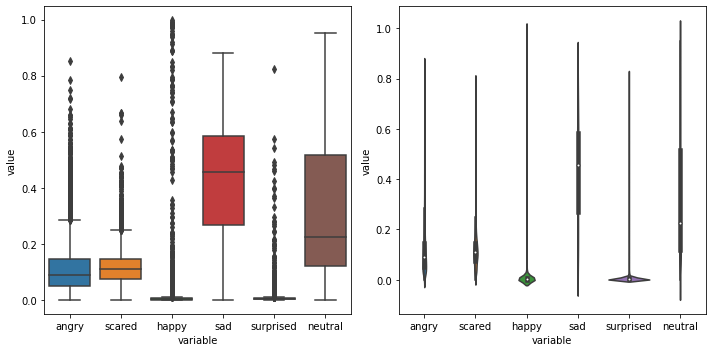

<IPython.core.display.Javascript object>

In [22]:
plot_df = mf[emotions]
plot_df = plot_df.melt()

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
sns.boxplot("variable", "value", data=plot_df, ax=axes[0])
sns.violinplot("variable", "value", data=plot_df, ax=axes[1])
plt.tight_layout()
plt.show()

In [23]:
def std_scale(x):
    return (x - np.mean(x)) / np.std(x)


mf[emotions] = mf[emotions].apply(std_scale)

<IPython.core.display.Javascript object>

In [24]:
aggs = {e: "mean" for e in emotions}
aggs["end_time"] = "count"

mean_song_emotion = mf.groupby("track_artist").agg(aggs)
mean_song_emotion = mean_song_emotion.rename(columns={"end_time": "n_samples"})

<IPython.core.display.Javascript object>

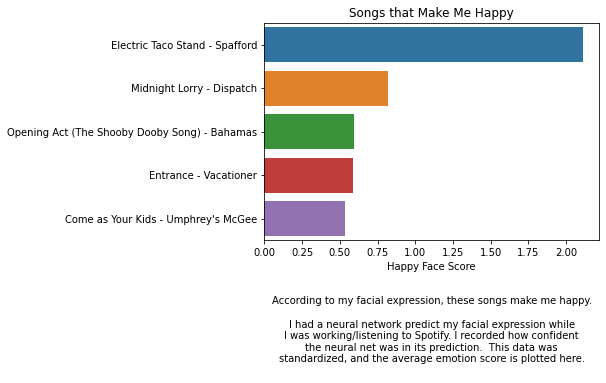

<IPython.core.display.Javascript object>

In [25]:
top_happy = mean_song_emotion.sort_values("happy", ascending=False)
top_happy = top_happy.reset_index().head()

top_happy["song_id"] = top_happy["track_artist"].str.replace(
    " - ", "\nby ", regex=False
)
sns.barplot(x="happy", y="track_artist", data=top_happy)
plt.ylabel("")
plt.xlabel(
    "Happy Face Score\n\n\n"
    "According to my facial expression, these songs make me happy.\n\n"
    "I had a neural network predict my facial expression while\n"
    "I was working/listening to Spotify. I recorded how confident\n"
    "the neural net was in its prediction.  This data was\n"
    "standardized, and the average emotion score is plotted here.\n"
)
plt.title("Songs that Make Me Happy")
plt.show()

In [48]:
songs = pd.merge(mean_song_emotion, song_feats, on="track_artist")

num_cols = songs.select_dtypes("number").columns
feat_cols = [c for c in num_cols if c not in emotions]

corrs_oi = songs.corr().loc[emotions, feat_cols]
tall_corrs_oi = corrs_oi.reset_index().melt("index")
tall_corrs_oi.columns = ["emotion", "feat", "corr"]

tall_corrs_oi["abs_corr"] = tall_corrs_oi["corr"].abs()
tall_corrs_oi.sort_values("abs_corr", ascending=False).head(10)

,emotion,feat,corr,abs_corr
0,angry,n_samples,-0.238459,0.238459
55,scared,liveness,-0.206944,0.206944
4,surprised,n_samples,0.199412,0.199412
77,neutral,duration_ms,-0.168598,0.168598
72,angry,duration_ms,0.160508,0.160508
30,angry,mode,-0.158707,0.158707
76,surprised,duration_ms,-0.157462,0.157462
53,neutral,instrumentalness,-0.157366,0.157366
59,neutral,liveness,0.157181,0.157181
67,scared,tempo,-0.154225,0.154225


<IPython.core.display.Javascript object>